# Trying out xarray-spatial

My specific goal is to use xarray-spatial's [zonal statistics function](https://makepath.github.io/xarray-spatial/zonal_statistics.html) to get summary stats for arbitrary regions defined by a raster "pixel map", the result of applying a "subpixel" orthorectification to GOES-16 and -17 imagery ("subpixel" because it resamples the original ~2 km resolution GOES imagery to the same resolution of the input DEM, such as 30 m NED), and then map those summary statistics. 

In [1]:
import xarray as xr
import xrspatial as xrs

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


**Defining Zones:**
Here I'm creating a grid of 3x3 zones giving each an "ID" (xarray-spatial will treach each unique value as a zone, even if the areas with that value aren't contiguous). Note that xarray-spatial will ignore any zones with a 0 value, and all values must be integers.

In [2]:
zones = np.array([[1, 1, 1, 2, 2, 2, 3, 3, 3],
                  [1, 1, 1, 2, 2, 2, 3, 3, 3],
                  [1, 1, 1, 2, 2, 2, 3, 3, 3],
                  [4, 4, 4, 5, 5, 5, 6, 6, 6], 
                  [4, 4, 4, 5, 5, 5, 6, 6, 6],
                  [4, 4, 4, 5, 5, 5, 6, 6, 6],
                  [7, 7, 7, 8, 8, 8, 9, 9, 9],
                  [7, 7, 7, 8, 8, 8, 9, 9, 9],
                  [7, 7, 7, 8, 8, 8, 9, 9, 9]], dtype=np.integer)
zones = xr.DataArray(zones, name='zones')

# Here's a 3d case, this should work with any n-dimensions
#zones_3d = xr.DataArray([zones,zones,zones,zones,zones,zones,zones,zones,zones], name='zones')

**Look at the zones data array**

In [3]:
zones

<xarray.DataArray 'zones' (dim_0: 9, dim_1: 9)>
array([[1, 1, 1, 2, 2, 2, 3, 3, 3],
       [1, 1, 1, 2, 2, 2, 3, 3, 3],
       [1, 1, 1, 2, 2, 2, 3, 3, 3],
       [4, 4, 4, 5, 5, 5, 6, 6, 6],
       [4, 4, 4, 5, 5, 5, 6, 6, 6],
       [4, 4, 4, 5, 5, 5, 6, 6, 6],
       [7, 7, 7, 8, 8, 8, 9, 9, 9],
       [7, 7, 7, 8, 8, 8, 9, 9, 9],
       [7, 7, 7, 8, 8, 8, 9, 9, 9]])
Dimensions without coordinates: dim_0, dim_1

**Plot the zones data array**

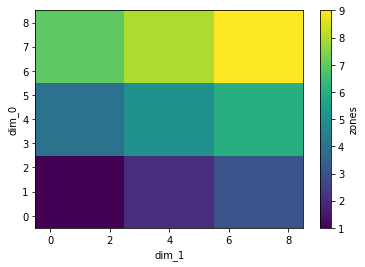

In [4]:
zones.plot()

**Create the data array:** (giving it randome values) from which we'll be computing summary stats

In [5]:
da = xr.DataArray(np.random.randn(9,9)*100, name='data')

# If we want to do a 3d data array
#da_3d = xr.DataArray(np.random.randn(9,9,9)*100)

**Plot the data array**

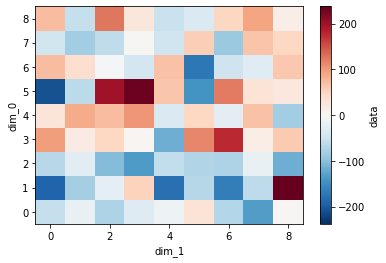

In [6]:
da.plot()

**Compute zonal stats** using the xarray-spatial function:

In [7]:
zonalstats = xrs.zonal.stats(zones, da, stat_funcs=['mean', 'max', 'min', 'std', 'var', 'count'])

**This returns a pandas dataframe**

In [8]:
zonalstats

,mean,max,min,std,var,count
1,-70.638382,-17.733535,-190.029667,50.135418,2513.560096,9.0
2,-51.853594,54.467469,-178.573285,70.057280,4908.022449,9.0
3,-43.875155,237.485906,-163.523251,111.115621,12346.681126,9.0
4,31.995172,200.422951,-207.760739,107.830338,11627.381882,9.0
5,31.107852,232.670451,-141.627421,111.268282,12380.630624,9.0
6,44.747460,178.834389,-83.354562,72.796170,5299.282397,9.0
7,7.324285,127.954362,-81.721764,69.902561,4886.367979,9.0
8,-21.374463,70.268474,-171.553452,68.819537,4736.128611,9.0
9,19.878029,94.040645,-88.144138,58.348267,3404.520234,9.0


**Convert to an xarray dataset** I want use this as a sort of "look up table" to map the summary stats values back into the original grid

In [9]:
zonalstats = xr.Dataset(zonalstats)

In [10]:
zonalstats

<xarray.Dataset>
Dimensions:  (dim_0: 9)
Coordinates:
  * dim_0    (dim_0) int64 1 2 3 4 5 6 7 8 9
Data variables:
    mean     (dim_0) float64 -70.64 -51.85 -43.88 32.0 ... 7.324 -21.37 19.88
    max      (dim_0) float64 -17.73 54.47 237.5 200.4 ... 128.0 70.27 94.04
    min      (dim_0) float64 -190.0 -178.6 -163.5 ... -81.72 -171.6 -88.14
    std      (dim_0) float64 50.14 70.06 111.1 107.8 111.3 72.8 69.9 68.82 58.35
    var      (dim_0) float64 2.514e+03 4.908e+03 ... 4.736e+03 3.405e+03
    count    (dim_0) float64 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0 9.0

**Map summary stats back to orignal grid shape with this function** 

(this is the method I came up with, but there's probably something more clever or simple that accomplishes the same thing)

In [11]:
def mapZonalStats(zones, zonalstats, stat_name):

    # create an empty array for this summary stat
    zonal_stat = np.zeros_like(zones.values)

    # for each zone
    for zone_n in zonalstats.dim_0.values:
        # get the summary stat for that zone, 
        # and assign it to the correct locations in the zonal_stat array
        zonal_stat[zones.values==zone_n] = zonalstats['{}'.format(stat_name)][zone_n-1]

    # convert this to an xarray data array with the proper name
    zonal_stat_da = xr.DataArray(zonal_stat, name='zonal_{}'.format(stat_name))
    
    return zonal_stat_da

**Apply this function for all our summary stats**

In [12]:
zonal_means = mapZonalStats(zones, zonalstats, 'mean')
zonal_max = mapZonalStats(zones, zonalstats, 'max')
zonal_min = mapZonalStats(zones, zonalstats, 'min')
zonal_std = mapZonalStats(zones, zonalstats, 'std')
zonal_var = mapZonalStats(zones, zonalstats, 'var')
zonal_count = mapZonalStats(zones, zonalstats, 'count')

**Combine all data arrays into a single dataset** 

Merge the original da, zones, and all the zonal stats together

In [13]:
ds = xr.merge([da, zones, zonal_means, zonal_max, zonal_min, zonal_std, zonal_var, zonal_count])

In [14]:
ds

<xarray.Dataset>
Dimensions:      (dim_0: 9, dim_1: 9)
Dimensions without coordinates: dim_0, dim_1
Data variables:
    data         (dim_0, dim_1) float64 -57.36 -17.73 -72.85 ... 94.04 16.62
    zones        (dim_0, dim_1) int64 1 1 1 2 2 2 3 3 3 1 ... 7 7 7 8 8 8 9 9 9
    zonal_mean   (dim_0, dim_1) int64 -70 -70 -70 -51 -51 ... -21 -21 19 19 19
    zonal_max    (dim_0, dim_1) int64 -17 -17 -17 54 54 54 ... 70 70 70 94 94 94
    zonal_min    (dim_0, dim_1) int64 -190 -190 -190 -178 ... -171 -88 -88 -88
    zonal_std    (dim_0, dim_1) int64 50 50 50 70 70 70 ... 68 68 68 58 58 58
    zonal_var    (dim_0, dim_1) int64 2513 2513 2513 4908 ... 3404 3404 3404
    zonal_count  (dim_0, dim_1) int64 9 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9 9

**Now we can plot all these, and they're all on the same grid**

Iterate through all eight data variables, plot

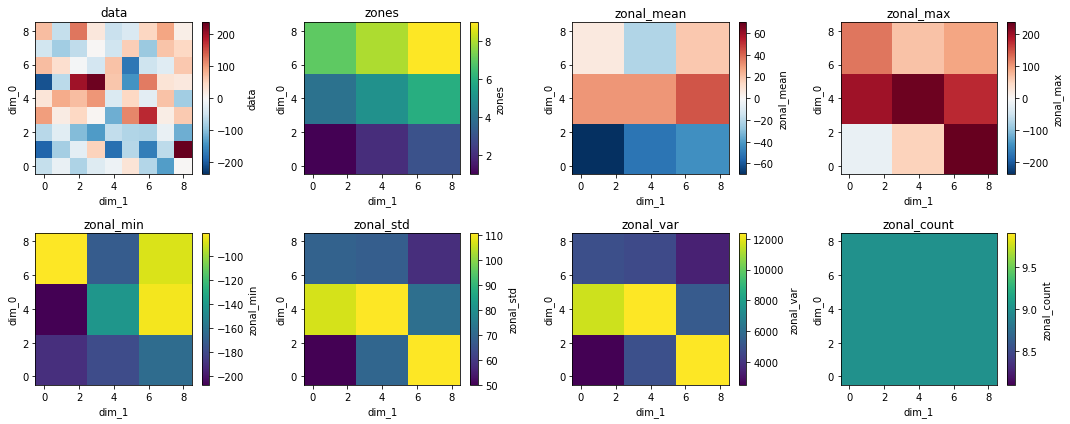

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,6), tight_layout=True)
ax = ax.flatten()

for i, data_var in enumerate(ds):
    ds[str(data_var)].plot(ax=ax[i])
    ax[i].set_title(str(data_var))